In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'fashion_mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteZ5PKOM/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteZ5PKOM/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


In [ ]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.image.grayscale_to_rgb(image)
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
print(train)
print(validation)
print(test)

<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


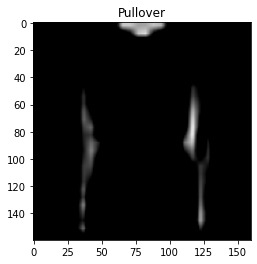

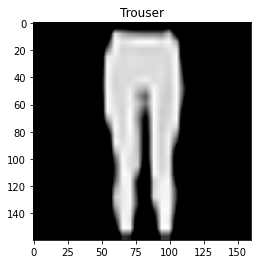

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 460ms/step - loss: 2.8401 - accuracy: 0.1203


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
1500/1500 [==============================] - 877s 585ms/step - loss: 0.4015 - accuracy: 0.8567 - val_loss: 0.3261 - val_accuracy: 0.8825
Epoch 2/10
1500/1500 [==============================] - 882s 588ms/step - loss: 0.3022 - accuracy: 0.8930 - val_loss: 0.3049 - val_accuracy: 0.8895
Epoch 3/10
1500/1500 [==============================] - 888s 592ms/step - loss: 0.2744 - accuracy: 0.9009 - val_loss: 0.3292 - val_accuracy: 0.8835
Epoch 4/10
1500/1500 [==============================] - 885s 590ms/step - loss: 0.2575 - accuracy: 0.9059 - val_loss: 0.2858 - val_accuracy: 0.9010
Epoch 5/10
1500/1500 [==============================] - 882s 588ms/step - loss: 0.2474 - accuracy: 0.9107 - val_loss: 0.2959 - val_accuracy: 0.8973
Epoch 6/10
1500/1500 [==============================] - 879s 586ms/step - loss: 0.2387 - accuracy: 0.9127 - val_loss: 0.2972 - val_accuracy: 0.8987
Epoch 7/10
1500/1500 [==============================] - 883s 589ms/step - loss: 0.2309 - accuracy: 0.9160 - val_

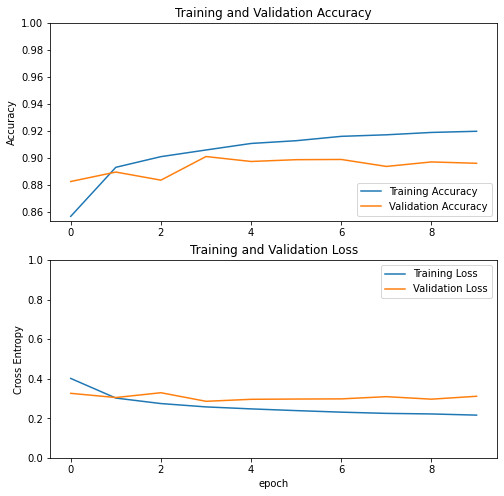

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

2

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
1500/1500 [==============================] - 862s 575ms/step - loss: 0.2118 - accuracy: 0.9237 - val_loss: 0.2941 - val_accuracy: 0.9013
Epoch 11/20
1500/1500 [==============================] - 862s 575ms/step - loss: 0.2082 - accuracy: 0.9249 - val_loss: 0.3036 - val_accuracy: 0.8993
Epoch 12/20
1500/1500 [==============================] - 866s 578ms/step - loss: 0.2053 - accuracy: 0.9243 - val_loss: 0.3153 - val_accuracy: 0.8957
Epoch 13/20
1500/1500 [==============================] - 880s 587ms/step - loss: 0.2031 - accuracy: 0.9245 - val_loss: 0.3043 - val_accuracy: 0.9017
Epoch 14/20
1500/1500 [==============================] - 893s 595ms/step - loss: 0.2016 - accuracy: 0.9254 - val_loss: 0.3191 - val_accuracy: 0.8960
Epoch 15/20
1500/1500 [==============================] - 901s 601ms/step - loss: 0.2003 - accuracy: 0.9268 - val_loss: 0.3211 - val_accuracy: 0.8970
Epoch 16/20
1500/1500 [==============================] - 897s 598ms/step - loss: 0.1954 - accuracy: 0.9281

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()